In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import string
import re
import nltk
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_text(url):
    response = requests.get(url)
    content = response.content
    parser = BeautifulSoup(content,'html.parser')
    return(parser.text)

In [3]:
def clean_text(script):
    script_clean=script.strip()
    script_clean=script_clean.replace("\n","")
    script_clean=script_clean.replace("\r"," ")
    script_clean=script_clean.replace("\r\n","")
    script_clean=re.sub("([\(\[]).*?([\)\]])", "", script_clean)
    script_clean=re.sub(r'\.([a-zA-Z])', r'. \1', script_clean) #remove missing whitespace between character lines.
    script_clean=re.sub(r'\!([a-zA-Z])', r'! \1', script_clean)
    script_clean=re.sub(r'\?([a-zA-Z])', r'? \1', script_clean)
    return(script_clean)

In [4]:
def get_cast(script_clean):
    tokens=nltk.word_tokenize(script_clean)
    cast=[]
    for word in tokens:
        if re.search("\\b[A-Z]{3,}\\b", word) is not None:
            cast.append(word)
    return(list(set(cast)))

In [5]:
script=get_text('http://www.chakoteya.net/DS9/575.htm')

In [6]:
script_clean=clean_text(script)

In [7]:
def get_lines(script_clean, cast):
    split_script=script_clean.split(':')
    lines_dict=dict.fromkeys(cast)
    for cast_member in cast:
        lines=[]
        for i in range(len(split_script)-1):
            if cast_member in split_script[i].strip().split(" "):
                line=split_script[i+1].strip().split(" ")
                line=[word for word in line if word != '']
                for member in cast:
                    if member in line:
                        line.remove(member)
                line=' '.join(line)
                lines.append(line)
        lines_dict[cast_member]=lines

    return(lines_dict)

In [8]:
def get_page_links():
    top_links=["http://www.chakoteya.net/DS9/episodes.htm", 
                   "http://www.chakoteya.net/StarTrek/episodes.htm", 
                   "http://www.chakoteya.net/NextGen/episodes.htm", 
                   "http://www.chakoteya.net/Voyager/episode_listing.htm", 
                   "http://www.chakoteya.net/Enterprise/episodes.htm"]
    short_links=["http://www.chakoteya.net/DS9/", 
                   "http://www.chakoteya.net/StarTrek/", 
                   "http://www.chakoteya.net/NextGen/", 
                   "http://www.chakoteya.net/Voyager/", 
                   "http://www.chakoteya.net/Enterprise/"]
    links_list=[]
    names_list=[]
    for i, link in enumerate(top_links):
        response = requests.get(link)
        content = response.content
        parser = BeautifulSoup(content,'html.parser')
        urls = parser.find_all('a')
        for page in urls:
            links_list.append(short_links[i]+str(page.get('href')))
            name=page.text
            name=name.replace('\r\n',' ')
            names_list.append(name)
            
    
    links_to_remove=['http://www.chakoteya.net/Voyager/fortyseven.htm',
                     'http://www.chakoteya.net/Voyager/LineCountS1-S3.htm',
                     'http://www.chakoteya.net/Voyager/LineCountS4-S7.htm',
                     'http://www.chakoteya.net/Enterprise/fortyseven.htm',
                    ]
    links_list=[link for link in links_list if (link.endswith('.htm')) & (link not in links_to_remove)]
    
    return(links_list)

In [9]:
# links_list

In [10]:
page_links=get_page_links()

In [11]:
len(page_links)

708

In [12]:
DS9_links = page_links[0:173]
TOS_links = page_links[173:253]
TAS_links = page_links[253:275]
TNG_links = page_links[275:451]
VOY_links = page_links[451:611]
ENT_links = page_links[611:708]

links=[DS9_links, TOS_links, TAS_links, TNG_links, VOY_links, ENT_links]

In [13]:
links_names=['DS9', 'TOS', 'TAS', 'TNG', 'VOY', 'ENT']
links=[DS9_links, TOS_links, TAS_links, TNG_links, VOY_links, ENT_links]

all_series_scripts={}
for i,series in enumerate(links):
    series_name=str(links_names[i])
    print(series_name)
    all_series_scripts[series_name]={}
    episode_script={}
    all_cast=[]
    for j,link in enumerate(series):
        episode="episode "+str(j)
        text=get_text(link)
        episode_script[episode]=text
    all_series_scripts[series_name]=episode_script

print(all_series_scripts)

DS9
TOS
TAS
TNG
VOY
ENT


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
with open('all_scripts_raw.json', 'w') as data:
    json.dump(all_series_scripts, data)

In [15]:
with open('all_scripts_raw.json', 'r') as data:
    all_scripts_raw = json.load(data)

In [16]:

links_names=['DS9', 'TOS', 'TAS', 'TNG', 'VOY', 'ENT']

all_series_lines={}
for i,series in enumerate(links_names):
    print(series)
    series_name=str(links_names[i])
    all_series_lines[series_name]={}
    all_lines_dict={}
    all_cast=[]
    #for j,episode in enumerate(all_series_scripts[series]):
    for j,episode in enumerate(all_scripts_raw[series]):
        #script=all_series_scripts[series][episode]
        script=all_scripts_raw[series][episode]
        cleaned_script=clean_text(script)
        cast=get_cast(cleaned_script)
        for member in cast:
            if member not in all_cast:
                all_cast.append(member)
        lines_dict=get_lines(cleaned_script,all_cast)
        all_lines_dict[episode]=lines_dict
    all_series_lines[series]=all_lines_dict

print(all_series_lines)

DS9
TOS
TAS
TNG
VOY
ENT


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
with open('all_series_lines.json', 'w') as data:
    json.dump(all_series_lines, data)

In [18]:
with open('all_series_lines.json', 'r') as data:
    all_series_lines = json.load(data)

In [19]:
#checking against source to make sure the character lines
#appear in the correct episode
all_series_lines['TNG']['episode 30']['LAFORGE']

["He said something about his new image. I tell you, he's been acting kind of strange lately.",
 "Well, if I didn't know better, I'd say he was showing signs of insecurity.",
 "I don't know. Sometimes I think he's becoming more human than any of us realise.",
 'Data?',
 'Can we come in?',
 'Did you damage your face, Data?',
 'Yes, Captain.',
 "I'm on my way.",
 'Now remember, this is a near warp transport, so the effects may be a little unusual.',
 'Try and hold still, will you, Data?',
 "I wish I knew what to suggest. I'm damned if I can find a thing wrong with him.",
 'What, are you saying that Data is losing his mind?',
 "Well, sir, it's just a guess, but, sometimes he wants to be human so badly he can taste it. I think he just tends to get confused when his human qualities surface.",
 "Witnessing Graves' death may have been some sort of catalyst for the way he",
 'Data. Data, can you hear me?',
 'Yeah.',
 'I think you just did.',
 'You can ask me anything you want.']

In [20]:
#writing the corrected df
# all_series_lines = pd.DataFrame(data=all_series_lines)
# all_series_lines.to_csv(r'C:\Users\Eric\Desktop\Star_Trek_Scripts-master\Star_Trek_Scripts-master\data\all_series_lines.csv')
#when I wrote it to a df spock ended up getting lines???????????????

In [21]:
episodes=all_series_lines['TNG'].keys()

In [22]:
total_lines_counts={}
line_counts_by_episode={}
for i,ep in enumerate(episodes):
    if i == 0:
        episode="Episode 1 & 2"
    else:
        episode="Episode "+str(i+2)
    line_counts_by_episode[episode]={}
    if all_series_lines['TNG'][ep] is not np.NaN:
        for member in list(all_series_lines['TNG'][ep].keys()):
            line_counts_by_episode[episode][member]=len(all_series_lines['TNG'][ep][member])
            if member in total_lines_counts.keys():
                total_lines_counts[member]=total_lines_counts[member]+len(all_series_lines['TNG'][ep][member])
            else:
                total_lines_counts[member]=len(all_series_lines['TNG'][ep][member])

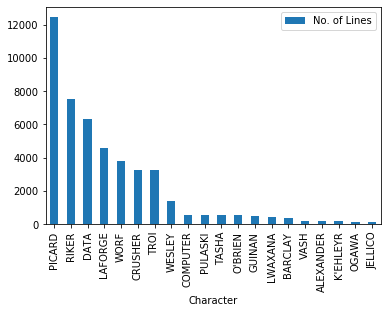

13        PICARD
12         RIKER
2           DATA
0        LAFORGE
21          WORF
16       CRUSHER
15          TROI
18        WESLEY
3       COMPUTER
162      PULASKI
6          TASHA
10       O'BRIEN
158       GUINAN
62       LWAXANA
333      BARCLAY
324         VASH
386    ALEXANDER
240     K'EHLEYR
266        OGAWA
617      JELLICO
Name: Character, dtype: object

In [23]:
#checking to make sure Spock doesn't appear, since that was an issue before
TNG_df_byep = pd.DataFrame(line_counts_by_episode)
# TNG_df_byep.loc['SPOCK']

TNG_df=pd.DataFrame(list(total_lines_counts.items()), columns=['Character','No. of Lines'])
Top20=TNG_df.sort_values(by='No. of Lines', ascending=False).head(20)

Top20.plot.bar(x='Character',y='No. of Lines')
plt.show()

Top20['Character']

In [25]:
# export_vis_TNG = TNG_df_byep.to_csv(r'C:\Users\Eric\Desktop\Star_Trek_Scripts-master\Star_Trek_Scripts-master\data\bar_chart_TNG')

In [ ]:
TNG_df_byep = pd.read_csv(r'C:\Users\Eric\Desktop\Star_Trek_Scripts-master\Star_Trek_Scripts-master\data\bar_chart_TNG')

In [26]:
#taking the ratings data from a different dataset
ratings_df = pd.read_csv('https://raw.githubusercontent.com/rikunert/Star_Trek_ratings/master/Star_Trek_data.csv')

In [24]:
characters = Top20['Character']
characters

13        PICARD
12         RIKER
2           DATA
0        LAFORGE
21          WORF
16       CRUSHER
15          TROI
18        WESLEY
3       COMPUTER
162      PULASKI
6          TASHA
10       O'BRIEN
158       GUINAN
62       LWAXANA
333      BARCLAY
324         VASH
386    ALEXANDER
240     K'EHLEYR
266        OGAWA
617      JELLICO
Name: Character, dtype: object

In [27]:
#slicing out just the TNG ratings
tng_ratings = ratings_df[ratings_df.title=='Star Trek: The Next Generation']
tng_ratings.head()

Unnamed: 0        date                       episode  rating  \
80           0  1987-09-26         Encounter at Farpoint     6.9   
81           0  1987-10-03                 The Naked Now     6.5   
82           0  1987-10-10                 Code of Honor     5.2   
83           0  1987-10-17              The Last Outpost     6.3   
84           0  1987-10-24  Where No One Has Gone Before     7.6   

                             title  
80  Star Trek: The Next Generation  
81  Star Trek: The Next Generation  
82  Star Trek: The Next Generation  
83  Star Trek: The Next Generation  
84  Star Trek: The Next Generation

In [28]:
#pulling out just the dates
tng_date = tng_ratings[['rating']]
row_tng_date = tng_date.T
row_tng_date

80   81   82   83   84   85   86   87   88   89   ...  246  247  248  \
rating  6.9  6.5  5.2  6.3  7.6  6.3  6.0  6.8  7.0  6.3  ...  7.8  6.1  6.7   

        249  250  251  252  253  254  255  
rating  7.2  6.5  6.8  6.6  6.6  7.9  8.6  

[1 rows x 176 columns]

In [29]:
#setting dates to the corresponding episode numbers
row_tng_date.columns = [list(TNG_df_byep)]
# index_rtg = row_tng_date.set_index(index_rtg.columns[0])
# row_tng_date = row_tng_date.str.replace('-', '')
row_tng_date

Episode 1 & 2 Episode 3 Episode 4 Episode 5 Episode 6 Episode 7  \
rating           6.9       6.5       5.2       6.3       7.6       6.3   

       Episode 8 Episode 9 Episode 10 Episode 11  ... Episode 168 Episode 169  \
rating       6.0       6.8        7.0        6.3  ...         7.8         6.1   

       Episode 170 Episode 171 Episode 172 Episode 173 Episode 174  \
rating         6.7         7.2         6.5         6.8         6.6   

       Episode 175 Episode 176 Episode 177  
rating         6.6         7.9         8.6  

[1 rows x 176 columns]

In [30]:
#making the dates a df
TNG_df_byep.head()

Episode 1 & 2  Episode 3  Episode 4  Episode 5  Episode 6  \
AARON                    NaN        NaN        NaN        NaN        NaN   
ACCOLAN                  NaN        NaN        NaN        NaN        NaN   
ADMINISTRATOR            NaN        NaN        NaN        NaN        NaN   
ADONIS                   NaN        NaN        NaN        NaN        NaN   
ADTH                     NaN        NaN        NaN        NaN        NaN   

               Episode 7  Episode 8  Episode 9  Episode 10  Episode 11  ...  \
AARON                NaN        NaN        NaN         NaN         NaN  ...   
ACCOLAN              NaN        NaN        NaN         NaN         NaN  ...   
ADMINISTRATOR        NaN        NaN        NaN         NaN         NaN  ...   
ADONIS               NaN        NaN        NaN         NaN         NaN  ...   
ADTH                 NaN        NaN        NaN         NaN         NaN  ...   

               Episode 168  Episode 169  Episode 170  Episode 171  \
AARON                  0.0          0.0          0.0          0.0   
ACCOLAN                0.0          0.0          0.0          0.0   
ADMINISTRATOR          0.0          0.0          0.0          0.0   
ADONIS                 0.0          0.0          0.0          0.0   
ADTH                   0.0          0.0          0.0          0.0   

               Episode 172  Episode 173  Episode 174  Episode 175  \
AARON                  0.0          0.0          0.0          0.0   
ACCOLAN                0.0          0.0          0.0          0.0   
ADMINISTRATOR          0.0          0.0          0.0          0.0   
ADONIS                 0.0          0.0          0.0          0.0   
ADTH                   0.0          0.0          0.0          0.0   

               Episode 176  Episode 177  
AARON                  0.0            0  
ACCOLAN                0.0            0  
ADMINISTRATOR          0.0            0  
ADONIS                 0.0            0  
ADTH                   0.0            0  

[5 rows x 176 columns]

In [31]:
T = TNG_df_byep.T
T['s'] = T.sum(axis=1)
T['s'].mean()
#calculating the average lines per episode

357.15340909090907

In [32]:
#grabbing the episode #s as the keys
# episode_show = np.array(columns_eps)

# dates = np.array(dates)
# dates
# episode_show_cat = np.concatenate((columns_eps, dates), axis=1)

In [33]:
episode_date_dict = dict(zip(TNG_df_byep.columns.values,row_tng_date.values.reshape(-1)))
exp = TNG_df_byep.reset_index().melt(id_vars='index')
exp['episode_air_date']=exp['variable'].map(episode_date_dict)
exp.head()

index       variable  value  episode_air_date
0          AARON  Episode 1 & 2    NaN               6.9
1        ACCOLAN  Episode 1 & 2    NaN               6.9
2  ADMINISTRATOR  Episode 1 & 2    NaN               6.9
3         ADONIS  Episode 1 & 2    NaN               6.9
4           ADTH  Episode 1 & 2    NaN               6.9

In [34]:
# exp['Character'] = exp['index']


In [35]:
exp = exp.rename(columns={'index':'Character', 
               'variable':'Episode', 
               'value':'Line_Count', 
               'episode_air_date':'Rating'
})
exp

Character        Episode  Line_Count  Rating
0               AARON  Episode 1 & 2         NaN     6.9
1             ACCOLAN  Episode 1 & 2         NaN     6.9
2       ADMINISTRATOR  Episode 1 & 2         NaN     6.9
3              ADONIS  Episode 1 & 2         NaN     6.9
4                ADTH  Episode 1 & 2         NaN     6.9
5                AIDE  Episode 1 & 2         NaN     6.9
6                AJUR  Episode 1 & 2         NaN     6.9
7               ALANS  Episode 1 & 2         NaN     6.9
8              ALBERT  Episode 1 & 2         NaN     6.9
9             ALEXANA  Episode 1 & 2         NaN     6.9
10          ALEXANDER  Episode 1 & 2         NaN     6.9
11          ALEXANDRA  Episode 1 & 2         NaN     6.9
12              ALIEN  Episode 1 & 2         NaN     6.9
13              ALKAR  Episode 1 & 2         NaN     6.9
14                ALL  Episode 1 & 2         NaN     6.9
15            ALLENBY  Episode 1 & 2         NaN     6.9
16              ALRIK  Episode 1 & 2         NaN     6.9
17             ALYSSA  Episode 1 & 2         NaN     6.9
18             AMANDA  Episode 1 & 2         NaN     6.9
19             AMARIE  Episode 1 & 2         NaN     6.9
20              ANAYA  Episode 1 & 2         NaN     6.9
21               ANNA  Episode 1 & 2         NaN     6.9
22               ANNE  Episode 1 & 2         NaN     6.9
23              ANNIE  Episode 1 & 2         NaN     6.9
24           ANTEDEAN  Episode 1 & 2         NaN     6.9
25          ANTEDEANS  Episode 1 & 2         NaN     6.9
26           ANTHWARA  Episode 1 & 2         NaN     6.9
27            ANTICAN  Episode 1 & 2         NaN     6.9
28               ANYA  Episode 1 & 2         NaN     6.9
29              APGAR  Episode 1 & 2         NaN     6.9
...               ...            ...         ...     ...
138834         VOICES    Episode 177         0.0     8.6
138835        VOLNOTH    Episode 177         0.0     8.6
138836          VORIN    Episode 177         0.0     8.6
138837          VOVAL    Episode 177         0.0     8.6
138838         WAGNOR    Episode 177         0.0     8.6
138839         WAITER    Episode 177         0.0     8.6
138840       WAITRESS    Episode 177         0.0     8.6
138841         WAKASA    Episode 177         0.0     8.6
138842         WESLEY    Episode 177         0.0     8.6
138843         WHALEN    Episode 177         0.0     8.6
138844          WHORE    Episode 177         0.0     8.6
138845       WILLIAMS    Episode 177         0.0     8.6
138846         WILLIE    Episode 177         0.0     8.6
138847          WOMAN    Episode 177         0.0     8.6
138848           WORD    Episode 177         0.0     8.6
138849           WORF    Episode 177        35.0     8.6
138850        WORKMAN    Episode 177         0.0     8.6
138851          WRENN    Episode 177         0.0     8.6
138852          WYATT    Episode 177         0.0     8.6
138853          YANAR    Episode 177         0.0     8.6
138854        YAREENA    Episode 177         0.0     8.6
138855            YOG    Episode 177         0.0     8.6
138856          YOUNG    Episode 177         0.0     8.6
138857         YRANAC    Episode 177         0.0     8.6
138858         YRANEC    Episode 177         0.0     8.6
138859           YUTA    Episode 177         0.0     8.6
138860         ZAHEVA    Episode 177         0.0     8.6
138861         ZAYNAR    Episode 177         0.0     8.6
138862           ZERO    Episode 177         0.0     8.6
138863           ZORN    Episode 177         0.0     8.6

[138864 rows x 4 columns]

In [36]:
testing = exp[exp['Character'].isin(characters)]
testing['Character'].value_counts()

PULASKI      176
WORF         176
OGAWA        176
O'BRIEN      176
PICARD       176
LWAXANA      176
JELLICO      176
VASH         176
CRUSHER      176
COMPUTER     176
BARCLAY      176
GUINAN       176
ALEXANDER    176
K'EHLEYR     176
RIKER        176
DATA         176
TASHA        176
TROI         176
WESLEY       176
LAFORGE      176
Name: Character, dtype: int64

In [37]:
#checking to make sure he doesn't crop back up
#having him grab lines out of thin air has been an issue
spock = exp[exp['Character']=='SPOCK']
spock_rating_ep108 = spock[spock['Episode']=='Episode 108']
spock_rating_ep108 = spock_rating_ep108.drop(['Episode', 'Rating'], axis=1)
spock_rating_ep108

Character  Line_Count
84303     SPOCK        77.0

In [38]:
exp.head()

Character        Episode  Line_Count  Rating
0          AARON  Episode 1 & 2         NaN     6.9
1        ACCOLAN  Episode 1 & 2         NaN     6.9
2  ADMINISTRATOR  Episode 1 & 2         NaN     6.9
3         ADONIS  Episode 1 & 2         NaN     6.9
4           ADTH  Episode 1 & 2         NaN     6.9

In [39]:
tidy_TNG = testing

In [40]:
tidy_TNG

Character        Episode  Line_Count  Rating
10      ALEXANDER  Episode 1 & 2         NaN     6.9
50        BARCLAY  Episode 1 & 2         NaN     6.9
126      COMPUTER  Episode 1 & 2         3.0     6.9
141       CRUSHER  Episode 1 & 2        35.0     6.9
148          DATA  Episode 1 & 2        60.0     6.9
251        GUINAN  Episode 1 & 2         NaN     6.9
317       JELLICO  Episode 1 & 2         NaN     6.9
334      K'EHLEYR  Episode 1 & 2         NaN     6.9
391       LAFORGE  Episode 1 & 2        15.0     6.9
428       LWAXANA  Episode 1 & 2         NaN     6.9
519       O'BRIEN  Episode 1 & 2         3.0     6.9
524         OGAWA  Episode 1 & 2         NaN     6.9
549        PICARD  Episode 1 & 2       184.0     6.9
566       PULASKI  Episode 1 & 2         NaN     6.9
595         RIKER  Episode 1 & 2       116.0     6.9
701         TASHA  Episode 1 & 2        34.0     6.9
738          TROI  Episode 1 & 2        45.0     6.9
752          VASH  Episode 1 & 2         NaN     6.9
767        WESLEY  Episode 1 & 2        20.0     6.9
774          WORF  Episode 1 & 2        31.0     6.9
799     ALEXANDER      Episode 3         NaN     6.5
839       BARCLAY      Episode 3         NaN     6.5
915      COMPUTER      Episode 3         0.0     6.5
930       CRUSHER      Episode 3        41.0     6.5
937          DATA      Episode 3        37.0     6.5
1040       GUINAN      Episode 3         NaN     6.5
1106      JELLICO      Episode 3         NaN     6.5
1123     K'EHLEYR      Episode 3         NaN     6.5
1180      LAFORGE      Episode 3        19.0     6.5
1217      LWAXANA      Episode 3         NaN     6.5
...           ...            ...         ...     ...
137805    O'BRIEN    Episode 176         0.0     7.9
137810      OGAWA    Episode 176         0.0     7.9
137835     PICARD    Episode 176        68.0     7.9
137852    PULASKI    Episode 176         0.0     7.9
137881      RIKER    Episode 176        18.0     7.9
137987      TASHA    Episode 176         0.0     7.9
138024       TROI    Episode 176         4.0     7.9
138038       VASH    Episode 176         0.0     7.9
138053     WESLEY    Episode 176         0.0     7.9
138060       WORF    Episode 176        20.0     7.9
138085  ALEXANDER    Episode 177         0.0     8.6
138125    BARCLAY    Episode 177         0.0     8.6
138201   COMPUTER    Episode 177         2.0     8.6
138216    CRUSHER    Episode 177        71.0     8.6
138223       DATA    Episode 177        88.0     8.6
138326     GUINAN    Episode 177         0.0     8.6
138392    JELLICO    Episode 177         0.0     8.6
138409   K'EHLEYR    Episode 177         0.0     8.6
138466    LAFORGE    Episode 177        66.0     8.6
138503    LWAXANA    Episode 177         0.0     8.6
138594    O'BRIEN    Episode 177        25.0     8.6
138599      OGAWA    Episode 177         2.0     8.6
138624     PICARD    Episode 177       289.0     8.6
138641    PULASKI    Episode 177         0.0     8.6
138670      RIKER    Episode 177        55.0     8.6
138776      TASHA    Episode 177        25.0     8.6
138813       TROI    Episode 177        37.0     8.6
138827       VASH    Episode 177         0.0     8.6
138842     WESLEY    Episode 177         0.0     8.6
138849       WORF    Episode 177        35.0     8.6

[3520 rows x 4 columns]

In [41]:
#this is our average rating for a TNG episode
#this will act as our baseline metric
tidy_TNG['Rating'].mean()

7.3749999999999

In [42]:
tidy_TNG.fillna(0, inplace=True)

C:\Users\Eric\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [43]:
#splitting the tidy_df into X and y
X = tidy_TNG.drop(['Rating', 'Episode'], axis=1)
y = tidy_TNG['Rating']

In [44]:
#adding a few libs I will need and splitting initially into train and test
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import category_encoders as ce

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [45]:
#checking the size of the train and test split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2992, 2), (528, 2), (2992,), (528,))

In [46]:
#further splitting into a val set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)


In [47]:
#checking the shape of the train and val splits
X_train.shape, X_val.shape, y_train.shape, y_val.shape
#our observations are large but the useful observations may be tiny
#considering the top 20 cast members are the only ones that will seriously
#have an impact 

((2543, 2), (449, 2), (2543,), (449,))

In [48]:
#first step is to get a new baseline on the y_val split
y_val.mean()
#slightly higher but essentially equal

7.323830734966603

In [49]:
X_train.describe()

Line_Count
count  2543.000000
mean     13.478962
std      25.918536
min       0.000000
25%       0.000000
50%       0.000000
75%      17.000000
max     289.000000

In [50]:
#checking direct correlations
tidy_TNG.corr()
#-1%

Line_Count    Rating
Line_Count    1.000000 -0.010101
Rating       -0.010101  1.000000

In [51]:
X_train.head()

Character  Line_Count
27763       DATA        58.0
116721      TROI         0.0
79674       WORF        32.0
128367    PICARD        98.0
100351      DATA         5.0

In [52]:
#checking randomforest 
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# pipeline1 = make_pipeline(
#     ce.TargetEncoder(min_samples_leaf=1, smoothing=1), 
#     SimpleImputer(strategy='median'), 
#     RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
# )

# k = 3
# scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
#                          scoring='neg_mean_absolute_error')
# print(f'MAE for {k} folds:', -scores)

In [53]:
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#creating a quick pipeline and MAE 

# pipeline2 = make_pipeline(
#     ce.OneHotEncoder(use_cat_names=True), 
#     SimpleImputer(strategy='mean'), 
#     StandardScaler(),
#     Ridge(alpha=1.0)
# )

# k = 3
# scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
#                          scoring='neg_mean_absolute_error')
# print(f'MAE for {k} folds:', -scores)

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans




pipeline3 = make_pipeline(
    ce.OrdinalEncoder(),
    LinearRegression(),

    
)

k = 3
scores = cross_val_score(pipeline3, X_train, y_train, cv=k, 
                         scoring='neg_mean_squared_error')
print(f'MSE for {k} folds:', -scores)

MSE for 3 folds: [0.79966177 0.86167716 0.837885  ]


In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans




pipeline4 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    LinearRegression(),

    
)

k = 3
scores = cross_val_score(pipeline4, X_train, y_train, cv=k, 
                         scoring='neg_mean_squared_log_error')
print(f'MSLE for {k} folds:', -scores)

MSLE for 3 folds: [0.01243621 0.01387353 0.01334716]


In [56]:
from sklearn.linear_model import BayesianRidge

pipe_baye = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    BayesianRidge()
)

scores = cross_val_score(pipeline4, X_train, y_train, cv=k, 
                         scoring='neg_mean_squared_log_error')
print(f'MSLE for {k} folds:', -scores)

MSLE for 3 folds: [0.01243621 0.01387353 0.01334716]


In [57]:
pipe_baye.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Character'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('bayesianridge',
                 BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                               compute_score=False, copy_X=True,
                               fit_intercept=True, lambda_1=1e-06,
                               lambda_2=1e-06, n_iter=300, normalize=False,
                               tol=0.001, verbose=False))],
         verbose=False)

In [58]:
pipe_baye.score(X_test, y_test)

-0.0017667967128103257

In [59]:
from joblib import dump

In [60]:
dump(pipeline4, 'pipeline4.joblib')

['pipeline4.joblib']

In [61]:
pipeline4.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Character'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [66]:
spock_rating_ep108

Character  Line_Count
84303     SPOCK        77.0

In [65]:
# pred = pd.DataFrame([['DATA', 25]])

pipeline4.predict(spock_rating_ep108)





array([7.32824186])

In [ ]:
dir(pipeline4)

In [ ]:
pipeline4.score(X_test, y_test)

In [ ]:
pipeline3.fit(X_train, y_train)
pipeline3.score(X_test, y_test)

In [ ]:
spock_rating_ep108

In [ ]:
df = pd.DataFrame(
    columns = ['Character', 'Line_Count'],
    data = [['PICARD', 143]]
)
df
y_pred = float(pipeline4.predict(df))
print(f'Projected Rating: {y_pred:0.01f}')
# y_pred

In [ ]:
len(y_pred)

In [ ]:
X_test

In [ ]:
pipeline4.named_steps['linearregression'].coef_

In [ ]:
def lines

In [ ]:
df = tidy_TNG

In [ ]:
import itertools
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression

def regression_3d(df, x_1, y_1, z, num=100, **kwargs):
    """
    Visualize linear regression in 3D: 2 features + 1 target
    
    df : Pandas DataFrame
    x : string, feature 1 column in df
    y : string, feature 2 column in df
    z : string, target column in df
    num : integer, number of quantiles for each feature
    """
    
    # Plot data
    fig = px.scatter_3d(df, x_1, y_1, z, **kwargs)
    
    # Fit Linear Regression
    features = [x_1, y_1]
    target = z
    model = LinearRegression()
    model.fit(df[features], df[target])    
    
    # Define grid of coordinates in the feature space
    xmin, xmax = df[x_1].min(), df[x_1].max()
    ymin, ymax = df[y_1].min(), df[y_1].max()
    xcoords = np.linspace(xmin, xmax, num)
    ycoords = np.linspace(ymin, ymax, num)
    coords = list(itertools.product(xcoords, ycoords))
    
    # Make predictions for the grid
    predictions = model.predict(coords)
    Z = predictions.reshape(num, num).T
    
    # Plot predictions as a 3D surface (plane)
    fig.add_trace(go.Surface(x_1=xcoords, y_1=ycoords, z=Z))
    
    return fig

In [ ]:
regression_3d(
    df,
    x_1='Character', 
    y_1='Line_Count', 
    z='Rating', 
    text='Episode', 
    title='TNG Ratings', 
    num=100
)